In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from scipy.special import softmax
from scipy.stats import mode

import warnings
from sklearn.exceptions import ConvergenceWarning

## 1: Supervised, Semi-Supervised, and Unsupervised Learning

### 1.a: download

In [2]:
df_wdbc = pd.read_csv('../data/wdbc.data', header=None)
# rename columns
feature_names = ['feature_{}'.format(i) for i in range(1, 31)]
df_wdbc.columns = ['ID', 'Diagnosis'] + feature_names
# clean up and encode
df_wdbc.drop(columns='ID', inplace=True)
df_wdbc['Diagnosis'] = df_wdbc['Diagnosis'].map({'M': 0, 'B': 1})
df_wdbc.head()

,Diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 1.b: Monte-Carlo Simulation

#### 1.b.i: supervised learning

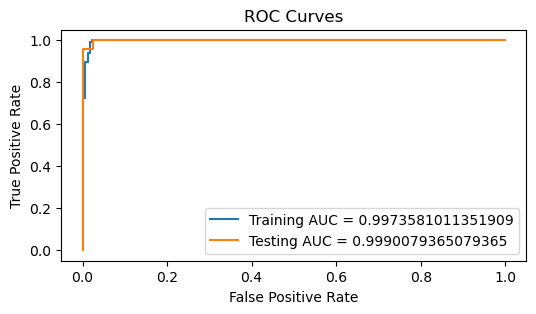

Training confusion matrix
: [[166   4]
 [  1 284]]
Testing confusion matrix
: [[41  1]
 [ 0 72]]
Overall performance:
train_accuracy: 0.9882
train_precision: 0.9848
train_recall: 0.9966
train_f1: 0.9907
train_auc: 0.9978
test_accuracy: 0.9664
test_precision: 0.9612
test_recall: 0.9870
test_f1: 0.9738
test_auc: 0.9908


In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

metrics_supervised = {
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'train_auc': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'test_auc': [],
}

for m in range(1, 31):
    # select train and test data
    X = df_wdbc.drop(columns='Diagnosis')
    y = df_wdbc['Diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    # normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # l1 penalized svm model
    model_svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    # CV
    param_grid = {'C': np.logspace(-4, 4, 10)}
    grid_search =  GridSearchCV(model_svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    # best model
    model_svm_best = grid_search.best_estimator_
    # evaluation
    y_train_pred = model_svm_best.predict(X_train_scaled)
    y_test_pred = model_svm_best.predict(X_test_scaled)
    y_train_proba = model_svm_best.decision_function(X_train_scaled)
    y_test_proba = model_svm_best.decision_function(X_test_scaled)
    # calculate and store into dict
    metrics_supervised['train_accuracy'].append(accuracy_score(y_train, y_train_pred))
    metrics_supervised['train_precision'].append(precision_score(y_train, y_train_pred))
    metrics_supervised['train_recall'].append(recall_score(y_train, y_train_pred))
    metrics_supervised['train_f1'].append(f1_score(y_train, y_train_pred))
    metrics_supervised['train_auc'].append(roc_auc_score(y_train, y_train_proba))
    metrics_supervised['test_accuracy'].append(accuracy_score(y_test, y_test_pred))
    metrics_supervised['test_precision'].append(precision_score(y_test, y_test_pred))
    metrics_supervised['test_recall'].append(recall_score(y_test, y_test_pred))
    metrics_supervised['test_f1'].append(f1_score(y_test, y_test_pred))
    metrics_supervised['test_auc'].append(roc_auc_score(y_test, y_test_proba))
    # plot ROC and confusion matrix for the last run
    if m == 30:
        # ROC
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
        plt.figure(figsize=(6, 3))
        plt.plot(fpr_train, tpr_train, label=f"Training AUC = {metrics_supervised['train_auc'][-1]}")
        plt.plot(fpr_test, tpr_test, label=f"Testing AUC = {metrics_supervised['test_auc'][-1]}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.show()
        # confusion matrix
        cm_train = confusion_matrix(y_train, y_train_pred)
        cm_test = confusion_matrix(y_test, y_test_pred)
        print("Training confusion matrix\n:", cm_train)
        print("Testing confusion matrix\n:", cm_test)

# overall performance over the 30 runs
avg_metrics_supervised = {k: np.mean(v) for k, v in metrics_supervised.items()}
print("Overall performance:")
for metric, value in avg_metrics_supervised.items():
    print(f"{metric}: {value:.4f}")

#### 1.b.ii: semi-supervised learning / self-training

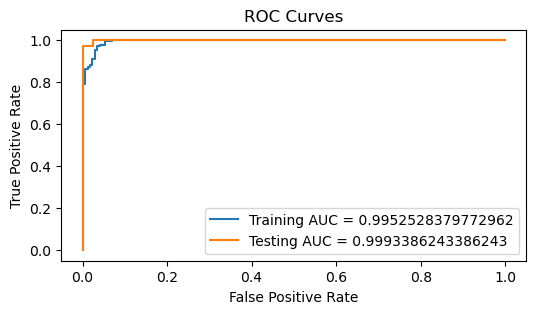

Training confusion matrix
: [[158  12]
 [  1 284]]
Testing confusion matrix
: [[42  0]
 [ 2 70]]
Overall performance:
train_accuracy: 0.9756
train_precision: 0.9707
train_recall: 0.9911
train_f1: 0.9807
train_auc: 0.9950
test_accuracy: 0.9611
test_precision: 0.9601
test_recall: 0.9796
test_f1: 0.9696
test_auc: 0.9885


In [4]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

metrics_semisupervised = {
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'train_auc': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'test_auc': [],
}

for m in range(1, 31):
    # prepare data
    X = df_wdbc.drop(columns='Diagnosis')
    y = df_wdbc['Diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # select labeled data and unlabeled data from training data using train_test_split
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)

    # A: train l1-penalized svm and choose penalty term using 5 fold cv
    model_svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    param_grid = {'C': np.logspace(-4, 4, 10)}
    grid_search =  GridSearchCV(model_svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_labeled, y_labeled)
    # best model
    model_svm_best = grid_search.best_estimator_

    # B: use labeled and unlabeled data for svm to do semi-supervised learning
    while X_unlabeled.size > 0:
        # current farthest unlabeled data
        distances = model_svm_best.decision_function(X_unlabeled)
        farthest_idx = np.argmax(np.abs(distances))
        farthest_X = X_unlabeled[farthest_idx]
        farthest_y = model_svm_best.predict(farthest_X.reshape(1, -1)) # let svm predict y (disregard previous y_unlabeled)
        # add it to labeled data
        X_labeled = np.vstack([X_labeled, farthest_X])
        y_labeled = np.append(y_labeled, farthest_y)
        # delete the used unlabled data
        X_unlabeled = np.delete(X_unlabeled, farthest_idx, axis=0)
        # retrain svm
        model_svm_best.fit(X_labeled, y_labeled)

    # evaluate on final model
    y_train_pred = model_svm_best.predict(X_train)
    y_test_pred = model_svm_best.predict(X_test)
    y_train_proba = model_svm_best.decision_function(X_train)
    y_test_proba = model_svm_best.decision_function(X_test)
    # calculate and store into dict
    metrics_semisupervised['train_accuracy'].append(accuracy_score(y_train, y_train_pred))
    metrics_semisupervised['train_precision'].append(precision_score(y_train, y_train_pred))
    metrics_semisupervised['train_recall'].append(recall_score(y_train, y_train_pred))
    metrics_semisupervised['train_f1'].append(f1_score(y_train, y_train_pred))
    metrics_semisupervised['train_auc'].append(roc_auc_score(y_train, y_train_proba))
    metrics_semisupervised['test_accuracy'].append(accuracy_score(y_test, y_test_pred))
    metrics_semisupervised['test_precision'].append(precision_score(y_test, y_test_pred))
    metrics_semisupervised['test_recall'].append(recall_score(y_test, y_test_pred))
    metrics_semisupervised['test_f1'].append(f1_score(y_test, y_test_pred))
    metrics_semisupervised['test_auc'].append(roc_auc_score(y_test, y_test_proba))
    # plot ROC and confusion matrix for the last run
    if m == 30:
        # ROC
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
        plt.figure(figsize=(6, 3))
        plt.plot(fpr_train, tpr_train, label=f"Training AUC = {metrics_semisupervised['train_auc'][-1]}")
        plt.plot(fpr_test, tpr_test, label=f"Testing AUC = {metrics_semisupervised['test_auc'][-1]}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.show()
        # confusion matrix
        cm_train = confusion_matrix(y_train, y_train_pred)
        cm_test = confusion_matrix(y_test, y_test_pred)
        print("Training confusion matrix\n:", cm_train)
        print("Testing confusion matrix\n:", cm_test)
        
# overall performance over the 30 runs
avg_metrics_semisupervised = {k: np.mean(v) for k, v in metrics_semisupervised.items()}
print("Overall performance:")
for metric, value in avg_metrics_semisupervised.items():
    print(f"{metric}: {value:.4f}")

#### 1.b.iii: unsupervised learning: kmeans

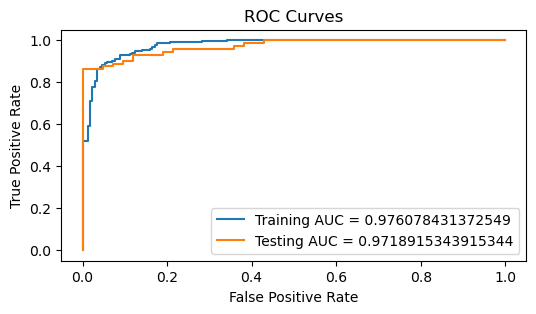

Training confusion matrix
: [[141  29]
 [  8 277]]
Testing confusion matrix
: [[34  8]
 [ 5 67]]
Overall performance:
train_accuracy: 0.9113
train_precision: 0.9045
train_recall: 0.9598
train_f1: 0.9313
train_auc: 0.4995
test_accuracy: 0.9006
test_precision: 0.9003
test_recall: 0.9486
test_f1: 0.9235
test_auc: 0.5038


In [13]:
metrics_kmeans = {
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'train_auc': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'test_auc': [],
}

for m in range(1, 31):
    # prepare data
    X = df_wdbc.drop(columns='Diagnosis')
    y = df_wdbc['Diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # A: run kmeans
    # kmeans: set random_state to current run# to make sure it's initialized randomly each run
    # kmeans has a default init=k-means++ which increases variability by random initialization, leading to better chance of good clustering
    # and thus avoid local minimum (ref: sklearn documentation)
    kmeans = KMeans(n_clusters=2, random_state=m, init='k-means++')
    kmeans.fit(X_train)
    cluster_centers = kmeans.cluster_centers_
    
    # B: assign labels using majority poll from clusters and evaluate on train data
    cluster_labels = []
    for center in cluster_centers:
        distances = np.linalg.norm(X_train - center, axis=1)
        nearest_indices = np.argsort(distances)[:30] # closest 30 points
        nearest_labels = y_train.iloc[nearest_indices]
        majority_label = mode(nearest_labels).mode # majority poll
        cluster_labels.append(majority_label)
    # predict label using kmeans based on cluster labels obtained previously
    train_distances = kmeans.transform(X_train)
    train_predict_labels = np.array([cluster_labels[i] for i in np.argmin(train_distances, axis=1)])
    # apply softmax to distances from cluster center to get probability for auc
    train_predict_proba = softmax(-train_distances, axis=1)[:, 0]
    # evaluate training metrics
    metrics_kmeans['train_accuracy'].append(accuracy_score(y_train, train_predict_labels))
    metrics_kmeans['train_precision'].append(precision_score(y_train, train_predict_labels))
    metrics_kmeans['train_recall'].append(recall_score(y_train, train_predict_labels))
    metrics_kmeans['train_f1'].append(f1_score(y_train, train_predict_labels))
    metrics_kmeans['train_auc'].append(roc_auc_score(y_train, train_predict_proba))

    # C: predict and evaluate on test data
    test_distances = kmeans.transform(X_test)
    test_predict_labels = np.array([cluster_labels[i] for i in np.argmin(test_distances, axis=1)])
    test_predict_proba = softmax(-test_distances, axis=1)[:, 0]
    metrics_kmeans['test_accuracy'].append(accuracy_score(y_test, test_predict_labels))
    metrics_kmeans['test_precision'].append(precision_score(y_test, test_predict_labels))
    metrics_kmeans['test_recall'].append(recall_score(y_test, test_predict_labels))
    metrics_kmeans['test_f1'].append(f1_score(y_test, test_predict_labels))
    metrics_kmeans['test_auc'].append(roc_auc_score(y_test, test_predict_proba))
    # plot ROC and confusion matrix for the last run
    if m == 30:
        # ROC
        fpr_train, tpr_train, _ = roc_curve(y_train, train_predict_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, test_predict_proba)
        plt.figure(figsize=(6, 3))
        plt.plot(fpr_train, tpr_train, label=f"Training AUC = {metrics_kmeans['train_auc'][-1]}")
        plt.plot(fpr_test, tpr_test, label=f"Testing AUC = {metrics_kmeans['test_auc'][-1]}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.show()
        # confusion matrix
        cm_train = confusion_matrix(y_train, train_predict_labels)
        cm_test = confusion_matrix(y_test, test_predict_labels)
        print("Training confusion matrix\n:", cm_train)
        print("Testing confusion matrix\n:", cm_test)

# overall performance over the 30 runs
avg_metrics_kmeans = {k: np.mean(v) for k, v in metrics_kmeans.items()}
print("Overall performance:")
for metric, value in avg_metrics_kmeans.items():
    print(f"{metric}: {value:.4f}")

#### 1.b.iv: spectral clustering

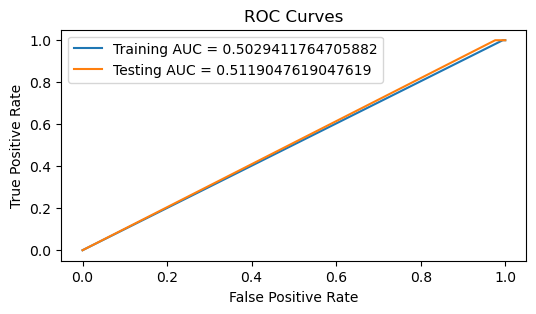

Training confusion matrix
: [[  1 169]
 [  0 285]]
Testing confusion matrix
: [[ 1 41]
 [ 0 72]]
Overall performance:
train_accuracy: 0.6292
train_precision: 0.6282
train_recall: 1.0000
train_f1: 0.7716
train_auc: 0.5041
test_accuracy: 0.6287
test_precision: 0.6160
test_recall: 0.9611
test_f1: 0.7507
test_auc: 0.5005


In [6]:
metrics_spectral = {
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'train_auc': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'test_auc': [],
}

for m in range(1, 31):
    # prepare data
    X = df_wdbc.drop(columns='Diagnosis')
    y = df_wdbc['Diagnosis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # spectral clustering
    spectral = SpectralClustering(n_clusters=2, gamma=1, random_state=m, affinity='rbf')
    cluster_assignments = spectral.fit_predict(X_train)
    # assign labels using majority vote with entire data
    cluster_labels = []
    cluster_probas = [] # for roc calculation
    for k in range(2):
        cluster_indices = np.where(cluster_assignments == k)[0]
        cluster_y = y_train.iloc[cluster_indices]
        majority_label = mode(cluster_y).mode
        majority_count = mode(cluster_y).count
        majority_percentage = majority_count / len(cluster_indices)
        cluster_labels.append(majority_label)
        cluster_probas.append(majority_percentage if majority_label == 1 else 1 - majority_percentage)
        
    # predict training data labels and probability
    train_predict_labels = np.array([cluster_labels[assignment] for assignment in cluster_assignments])
    train_predict_proba = np.array([cluster_probas[assignment] for assignment in cluster_assignments])
    
    # evaluate on training data
    metrics_spectral['train_accuracy'].append(accuracy_score(y_train, train_predict_labels))
    metrics_spectral['train_precision'].append(precision_score(y_train, train_predict_labels))
    metrics_spectral['train_recall'].append(recall_score(y_train, train_predict_labels))
    metrics_spectral['train_f1'].append(f1_score(y_train, train_predict_labels))
    metrics_spectral['train_auc'].append(roc_auc_score(y_train, train_predict_proba))
    
    # predict and evaluate on test data
    test_assignments = spectral.fit_predict(X_test)
    test_predict_labels = np.array([cluster_labels[assignment] for assignment in test_assignments])
    test_predict_proba = np.array([cluster_probas[assignment] for assignment in test_assignments])
    metrics_spectral['test_accuracy'].append(accuracy_score(y_test, test_predict_labels))
    metrics_spectral['test_precision'].append(precision_score(y_test, test_predict_labels))
    metrics_spectral['test_recall'].append(recall_score(y_test, test_predict_labels))
    metrics_spectral['test_f1'].append(f1_score(y_test, test_predict_labels))
    metrics_spectral['test_auc'].append(roc_auc_score(y_test, test_predict_proba))

    # plot ROC and confusion matrix for the last run
    if m == 30:
        # ROC
        fpr_train, tpr_train, _ = roc_curve(y_train, train_predict_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, test_predict_proba)
        plt.figure(figsize=(6, 3))
        plt.plot(fpr_train, tpr_train, label=f"Training AUC = {metrics_spectral['train_auc'][-1]}")
        plt.plot(fpr_test, tpr_test, label=f"Testing AUC = {metrics_spectral['test_auc'][-1]}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.show()
        # confusion matrix
        cm_train = confusion_matrix(y_train, train_predict_labels)
        cm_test = confusion_matrix(y_test, test_predict_labels)
        print("Training confusion matrix\n:", cm_train)
        print("Testing confusion matrix\n:", cm_test)

# overall performance over the 30 runs
avg_metrics_spectral = {k: np.mean(v) for k, v in metrics_spectral.items()}
print("Overall performance:")
for metric, value in avg_metrics_spectral.items():
    print(f"{metric}: {value:.4f}")

#### 1.b.v: comparing supervised, semisupervised, and unsupervised learning result

From the metrics result obtained above, supervised learning indeed performs better then semisupervised learning with an average of 1-3% higher metric across all metrics. Unsupervised learning, on the other hand, underperforms. Kmeans is able to obtain an average metrics of 5-10% lower than the supervised learning case, but it has significantly lower auc for both traning and testing set. Spectral clustering underperforms significantly compared to others with an around 20-30% drop in all metrics compared to other methods.

## 2. Active Learning using SVM

### 2.a: download and prepare data

In [7]:
df_banknote = pd.read_csv('../data/data_banknote_authentication.txt', header=None)
feature_names = ['feature_{}'.format(i) for i in range(1, 5)]
df_banknote.columns = feature_names + ['class']
df_banknote.head()

,feature_1,feature_2,feature_3,feature_4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [8]:
X = df_banknote.drop(columns='class')
y = df_banknote['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=472)

### 2.b: incrementally train SVMs 

#### 2.b.i: passive learning: SVM with randomly selected data batch

In [9]:
all_test_errors_passive = []

for i in range(50):
    test_errors_passive = []
    # keep track of iterative data selection
    working_df = pd.concat([X_train, y_train], axis=1)
    cumulative_train_df = pd.DataFrame(columns=working_df.columns)
    while not working_df.empty:
        curr_sample = working_df.sample(n=10) # select 10 random sample
        working_df.drop(curr_sample.index, inplace=True) # remove selected sample
        cumulative_train_df = pd.concat([cumulative_train_df, curr_sample])
        # select X and y
        X_train_cumu = cumulative_train_df.drop(columns='class')
        y_train_cumu = cumulative_train_df['class'].astype('int')
        # train svm on current sample
        svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)
        param_grid = {'C': np.logspace(-4, 4, 10)}
        grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train_cumu, y_train_cumu)
        svm_best = grid_search.best_estimator_
        # evaluate current svm and store metrics
        y_pred = svm_best.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_pred)
        test_errors_passive.append(test_error)
    # record all test errors
    all_test_errors_passive.append(test_errors_passive)

/var/folders/cm/ylzm16q53fgck3vjks9517yc0000gn/T/ipykernel_53796/2030642183.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cumulative_train_df = pd.concat([cumulative_train_df, curr_sample])
/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more de

#### 2.b.ii: active learning: SVM with closest data batch

In [10]:
all_test_errors_active = []

for i in range(50):
    test_errors_active = []
    # keep track of iterative data selection
    working_df = pd.concat([X_train, y_train], axis=1)
    # start with 10 random data
    cumulative_train_df = working_df.sample(n=10)
    working_df.drop(cumulative_train_df.index, inplace=True)

    # inital svm
    X_train_cumu = cumulative_train_df.drop(columns='class')
    y_train_cumu = cumulative_train_df['class'].astype('int')
    # train svm on current sample
    svm = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    param_grid = {'C': np.logspace(-4, 4, 10)}
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_cumu, y_train_cumu)
    svm_best = grid_search.best_estimator_
    # evaluate initial svm and store metrics
    y_pred = svm_best.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    test_errors_active.append(test_error)
    
    while not working_df.empty:
        # sample closest 10 data point for the next iteration
        X_remaining = working_df.drop(columns='class')
        distances = svm_best.decision_function(X_remaining)
        closest_indices = np.argsort(np.abs(distances))[:10]
        closest_samples = working_df.iloc[closest_indices]
        # if all selected data are the same class, select another 10 random samples
        if closest_samples['class'].nunique() == 1:
            closest_samples = working_df.sample(n=10)
        working_df.drop(closest_samples.index, inplace=True) # drop selected data
        cumulative_train_df = pd.concat([cumulative_train_df, closest_samples]) # update training data
        # retrain svm and evaluate
        X_train_cumu = cumulative_train_df.drop(columns='class')
        y_train_cumu = cumulative_train_df['class'].astype('int')
        grid_search.fit(X_train_cumu, y_train_cumu)
        svm_best = grid_search.best_estimator_
        y_pred = svm_best.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_pred)
        test_errors_active.append(test_error)
        
    # record all test errors
    all_test_errors_active.append(test_errors_active)

/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/peterxu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_sp

### 2.c: test error evaluation

Average test error for passive learning is: 0.015311205273069655
Average test error for active learning is: 0.013154425612052704


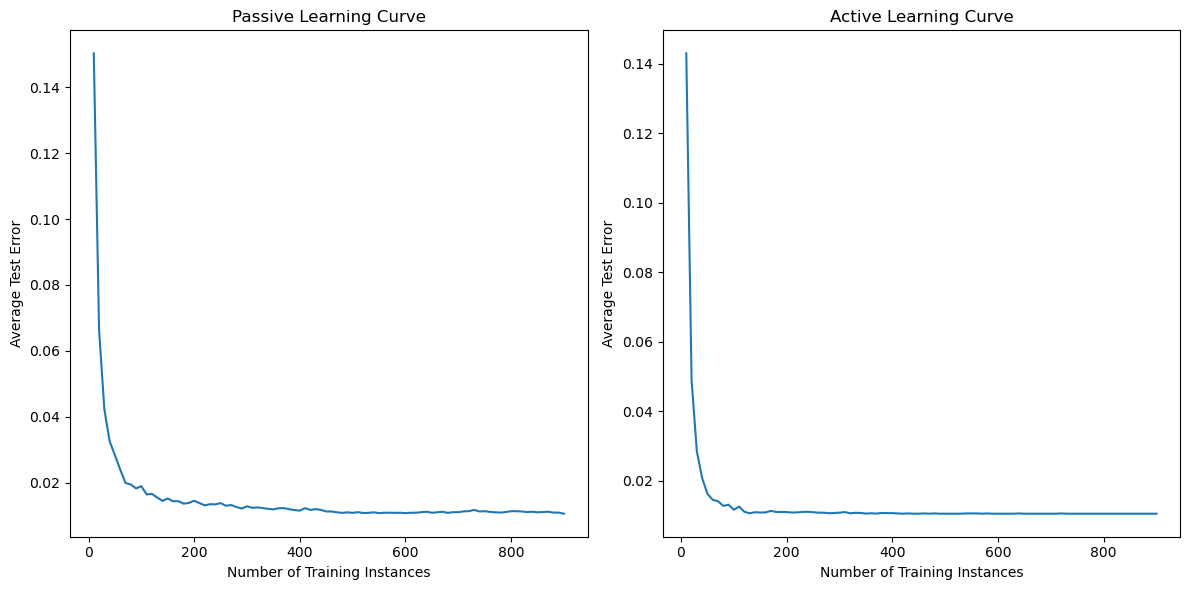

In [11]:
# average total error
avg_test_errors_passive = np.mean(all_test_errors_passive)
avg_test_errors_active = np.mean(all_test_errors_active)
print(f"Average test error for passive learning is: {avg_test_errors_passive}")
print(f"Average test error for active learning is: {avg_test_errors_active}")

# plot learning curve
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
num_train_instance = np.arange(10, 910, 10)
# passive learning curve
axs[0].plot(num_train_instance, np.mean(all_test_errors_passive, axis=0))
axs[0].set_title('Passive Learning Curve')
axs[0].set_xlabel('Number of Training Instances')
axs[0].set_ylabel('Average Test Error')
# active learning curve
axs[1].plot(num_train_instance, np.mean(all_test_errors_active, axis=0))
axs[1].set_title('Active Learning Curve')
axs[1].set_xlabel('Number of Training Instances')
axs[1].set_ylabel('Average Test Error')
plt.tight_layout()